In [1]:
import os
import time
import uuid
import cv2
import time
from djitellopy import tello

In [2]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

In [3]:
import random
import re

In [4]:
import albumentations as alb

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Resizing, Rescaling, Input, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

In [6]:
base_path = '../data/one_class'

# Generate data

## Gather images

In [3]:
IMAGES_PATH = os.path.join('..', 'data', 'images', 'no_hand')
number_images = 5

In [4]:
# Image capturing with Tello drone

me = tello.Tello()
me.connect()
print(me.get_battery())

me.streamon()

time_start = time.time() + 1
for imgnum in range(number_images):
    while True:
        img = me.get_frame_read().frame
        img = cv2.resize(img, (360, 240))
        
        if time.time() >= time_start:
            print(f'Collecting image {imgnum}')
            imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
            cv2.imwrite(imgname, img)
            cv2.circle(img, (180, 120), 10, (0, 255, 0), cv2.FILLED)
            break
                
        cv2.imshow("Image", img)
        cv2.waitKey(1)
    
    cv2.imshow("Image", img)
    cv2.waitKey(1)
    
    time.sleep(0.5)
    time_start = time.time() + 2
                
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

me.streamoff()
cv2.destroyAllWindows()

[INFO] tello.py - 122 - Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
[INFO] tello.py - 437 - Send command: 'command'
[INFO] tello.py - 461 - Response command: 'ok'
[INFO] tello.py - 437 - Send command: 'streamon'
[INFO] tello.py - 461 - Response streamon: 'ok'


100


[INFO] tello.py - 437 - Send command: 'streamoff'
[INFO] tello.py - 461 - Response streamoff: 'ok'


## Review images

In [12]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

RuntimeError: Physical devices cannot be modified after being initialized

In [70]:
X = []
images_path = os.path.join(base_path, 'images')

for file in os.listdir(images_path):
                # load the image
                img = load_img(os.path.join(images_path, file))
                # convert it to an array
                img_array = np.array(img)
                # append the array to X
                X.append(img_array)

X = np.array(X)

In [71]:
os.path.join(base_path, 'images')

'../data/one_class/images'

In [72]:
X.shape

(240, 240, 360, 3)

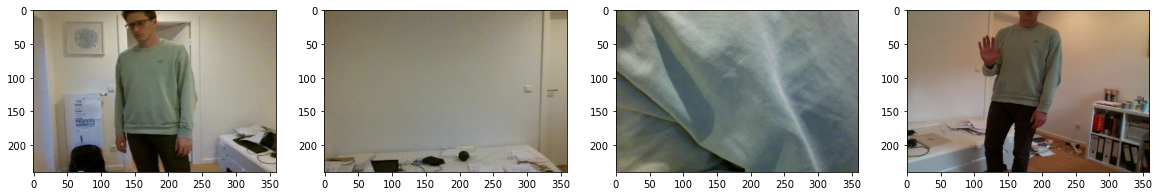

In [73]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(X[:4]):
    ax[idx].imshow(image)
plt.show()

## Label images

_Use label me to draw boxes around all hands and mark with class name (e.g. no_hand, fist etc.)_

In [10]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: /Users/philipwitte/.labelmerc


## Partition unaugmented data

In [196]:
# Create 'train', 'val' and 'test' folder within 'images' and 'labels' folders:
for partition in ['train', 'val', 'test']:
    for data_type in ['images', 'labels']:
        if partition not in os.listdir(os.path.join(base_path, data_type)):
            os.mkdir(os.path.join(base_path, data_type, partition))

In [226]:
# Put images into regarding folders (randomly)
# First create list of all file_names
file_list = []
for file in os.listdir(os.path.join(base_path, 'images')):
    if re.findall(r'\.jpg', file):
        file_list.append(file)
len(file_list)

0

In [225]:
#... then define sizes of datasets...
train_size = int(0.7 * len(file_list))
val_size = int(0.15 * len(file_list))
test_size = len(file_list) - train_size - val_size

train_size, val_size, test_size

(0, 0, 0)

In [224]:
# ...and finally move files randomly into target folders
for partition, sample_size in zip(['train', 'val', 'test'], [train_size, val_size, test_size]):
    selected_images = random.sample(file_list, sample_size)
    file_list = [image for image in file_list if image not in selected_images]
    for image in selected_images:
        os.rename(os.path.join(base_path, 'images', image), os.path.join(base_path, 'images', partition, image))

In [233]:
# Afterwards labels can be shifted accordingly
count_no_labels = 0
for partition in ['train', 'val', 'test']:
    for image in os.listdir(os.path.join(base_path, 'images', partition)):
        label_name = image[:-3] + 'json'
        try: 
            os.rename(os.path.join(base_path,'labels', label_name), 
                  os.path.join(base_path,'labels', partition, label_name))
        except:
            count_no_labels += 1
print(f'in total {count_no_labels} not found')

No label available for b6874222-e110-11ec-ae3a-8a15287fd426.jpg
No label available for 2a3b73be-e111-11ec-ae3a-8a15287fd426.jpg
No label available for c7cce4fa-e111-11ec-ae3a-8a15287fd426.jpg
No label available for 1fb650f8-e111-11ec-ae3a-8a15287fd426.jpg
No label available for d2526a58-e111-11ec-ae3a-8a15287fd426.jpg
No label available for a83b5c5c-e111-11ec-ae3a-8a15287fd426.jpg
No label available for d9d82ed4-e111-11ec-ae3a-8a15287fd426.jpg
No label available for d8580610-e111-11ec-ae3a-8a15287fd426.jpg
No label available for b744e984-e111-11ec-ae3a-8a15287fd426.jpg
No label available for 22b83c44-e111-11ec-ae3a-8a15287fd426.jpg
No label available for 3dc46ff8-e111-11ec-ae3a-8a15287fd426.jpg
No label available for 1b34d068-e111-11ec-ae3a-8a15287fd426.jpg
No label available for c715ccd0-e110-11ec-ae3a-8a15287fd426.jpg
No label available for efb1031c-e110-11ec-ae3a-8a15287fd426.jpg
No label available for e82b83ec-e110-11ec-ae3a-8a15287fd426.jpg
No label available for 1e361880-e111-11e

# Perform image augmentation

## Create augmentor with albumentation

In [455]:
augmentor = alb.Compose([alb.RandomBrightnessContrast((-0.2, 0.4), p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.augmentations.geometric.transforms.Affine(
                             translate_percent=(-0.20, 0.20), 
                             rotate=(-5,5),
                             mode=cv2.BORDER_CONSTANT,p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

## Use augmentor for a single image

In [456]:
img = cv2.imread(os.path.join(base_path, 'images', 'train', '1c6bc3e6-e0f4-11ec-ae3a-8a15287fd426.jpg'))

In [457]:
with open(os.path.join(base_path, 'labels', 'train', '1c6bc3e6-e0f4-11ec-ae3a-8a15287fd426.json'), 'r') as f:
    label = json.load(f)

In [458]:
type(label)

dict

In [459]:
label['shapes']

[{'label': 'straight_hand',
  'points': [[12.171052631578947, 8.868421052631579],
   [79.9342105263158, 88.47368421052632]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}}]

In [460]:
class_label = label['shapes'][0]['label']
class_label

'straight_hand'

In [461]:
points = label['shapes'][0]['points']
points

[[12.171052631578947, 8.868421052631579],
 [79.9342105263158, 88.47368421052632]]

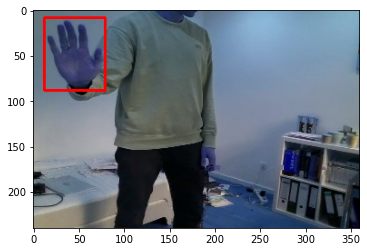

In [462]:
cv2.rectangle(img,
              tuple([int(i) for i in points[0]]),
              tuple([int(i) for i in points[1]]),
              (255, 0, 0), 2)

plt.imshow(img)

In [463]:
# Convert coordinates into a one-dimensional list
coords = []
for coord_list in points:
    for coord in coord_list:
        coords.append(coord)
coords

[12.171052631578947, 8.868421052631579, 79.9342105263158, 88.47368421052632]

In [464]:
# Convert into 'alubmentations' format, i.e. relative to img dimensions
coords = list(np.divide(coords, [360, 240, 360, 240]))
coords

[0.03380847953216374,
 0.03695175438596491,
 0.22203947368421054,
 0.368640350877193]

In [465]:
# Augment image using the defined augmentor
augmented = augmentor(image=img, bboxes=[coords], class_labels=['straight_hand'])

In [466]:
# Output is a dictionary
type(augmented)

dict

In [467]:
# Image, bbox and class labels are keys
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

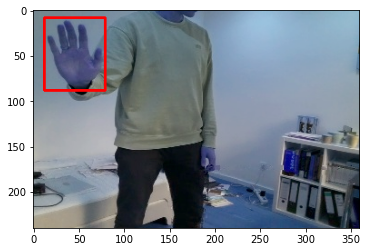

In [468]:
# Draw augmented image incl. bbox
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [360, 240]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [360, 240]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented['image'])

## Perform augmentation and partition data

In [469]:
if os.path.exists(os.path.join(base_path, 'augmented')):
    for data_type in ['images', 'labels']:
        for partition in ['train', 'val', 'test']:
            if os.path.exists(os.path.join(base_path, 'augmented', data_type, partition)):
                for file in os.listdir(os.path.join(base_path, 'augmented', data_type, partition)):
                    os.remove(os.path.join(base_path, 'augmented', data_type, partition, file))

In [470]:
# Create new directories for augmented images and labels
try:
    os.mkdir(os.path.join(base_path, 'augmented'))
except:
    print('augmented folder already exists.')

for data_type in ['images', 'labels']:
    try:
        os.mkdir(os.path.join(base_path, 'augmented', data_type))
    except:
        print(f'{data_type} folder exists already.')
    for partition in ['train', 'val', 'test']:
        try:
            os.mkdir(os.path.join(base_path, 'augmented', data_type, partition))
        except:
            print(f'{partition} folder within {data_type} exists already.')

augmented folder already exists.
images folder exists already.
train folder within images exists already.
val folder within images exists already.
test folder within images exists already.
labels folder exists already.
train folder within labels exists already.
val folder within labels exists already.
test folder within labels exists already.


In [471]:
# Augment images and save in regarding folders augemneted/images and augmented/labels
for partition in ['train', 'val', 'test']:
    partition_dir = os.path.join(base_path, 'images', partition)
    for image_name in os.listdir(partition_dir):
      
        # Load image
        image = cv2.imread(os.path.join(partition_dir, image_name))
        
        # In case no label is available, coordinates and class_label are predefined
        class_label = 'no_hand'
        coords = [0, 0, 0.00001, 0.00001] # x_max / y_max need to be > 0 for augmentor!
        
        # Load label (if exists) and get coordinates of box & class_name
        label_path = os.path.join(base_path, 'labels', partition, image_name[:-3] + 'json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            # Get class name
            class_label = label['shapes'][0]['label']
            
            # Get coordinates of bbox and scale them
            i = 0    
            for coord_list in label['shapes'][0]['points']:
                for coord in coord_list:
                    coords[i] = coord
                    i += 1
            coords = list(np.divide(coords, [360, 240, 360, 240]))
            
            # Change points, if max point is saved in first position
            if coords[0] > coords[2]:
                coords = coords[-2:] + coords[:2]
        
        # Save augmented image and annotation file
        try:
            if partition == 'train':    
                for i in range(20):
                    # Utilize augmentor
                    augmented = augmentor(image = image, bboxes=[coords], class_labels=[class_label])

                    # Save image
                    image_path = os.path.join(base_path, 'augmented', 'images', partition, 
                                             image_name[:-3] + f'{i}' + '.jpg')
                    cv2.imwrite(image_path, augmented['image'])


                    # Create annotation
                    annotation = {}
                    annotation['image'] = image_path

                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0                    ### potentially to be replaced with class_label!!!

                    if os.path.exists(label_path):
                        annotation['bbox'] = list(augmented['bboxes'][0])
                        annotation['class'] = 1                ### potentially to be replaced with class_label!!!

                    # Save annotations
                    with open(os.path.join(base_path, 'augmented', 'labels', partition, 
                                           image_name[:-3] + f'{i}' + '.json'), 'w') as f:
                        json.dump(annotation, f)
            else:
                # Save image
                image_path = os.path.join(base_path, 'augmented', 'images', partition, image_name)
                cv2.imwrite(image_path, image)


                # Create annotation
                annotation = {}
                annotation['image'] = image_path

                annotation['bbox'] = [0, 0, 0, 0]
                annotation['class'] = 0                    ### potentially to be replaced with class_label!!!

                if os.path.exists(label_path):
                    annotation['bbox'] = coords
                    annotation['class'] = 1                ### potentially to be replaced with class_label!!!

                # Save annotations
                with open(os.path.join(base_path, 'augmented', 'labels', partition, 
                                       image_name[:-3] + f'{0}' + '.json'), 'w') as f:
                    json.dump(annotation, f)
                
        
        except Exception as e:
            print(e)
            
# Comment: Labelme saves first click as x_min and second click as x_max. That means if the rectangle has been 
# drawn from right bottom corner to left top corner a error message will be sent by augmentor 

image must be numpy array type


## Build augmentation pipeline (tf.dataset)

In [472]:
# Load image from file
def load_img(jpeg_file):
    byte_img = tf.io.read_file(jpeg_file)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [473]:
# Create tf dataset from images
X = []
for partition in ['train', 'val', 'test']:
    
    # Create a dataset of all files matching a pattern
    X_i = tf.data.Dataset.list_files(os.path.join(base_path, 'augmented', 'images', partition, '*.jpg'), 
                                         shuffle=False)
    # Read file and decode into jpeg format
    X_i = X_i.map(load_img)
    
    # Save in list 
    X.append(X_i)

X_train = X[0]
X_val = X[1]
X_test = X[2]

In [474]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [475]:
X_train.as_numpy_iterator().next()

array([[[174, 157, 127],
        [172, 155, 125],
        [172, 156, 130],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[173, 156, 126],
        [172, 155, 125],
        [172, 156, 130],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[172, 155, 125],
        [171, 154, 124],
        [173, 156, 130],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   1,   0],
        [  0,   1,   0],
        [  0,   1,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   2,   0],
        [  0,   2,   0],
        [  0,   2,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [476]:
# Function to load json files
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [477]:
# Create tf dataset for labels
y = []
for partition in ['train', 'val', 'test']:
    # Create a dataset of all files matching a pattern
    y_i = tf.data.Dataset.list_files(os.path.join(base_path, 'augmented', 'labels', partition, '*.json'), 
                                         shuffle=False)
    
    # Read file and decode into jpeg format (py_function wraps a python function into a TensorFlow op)
    y_i = y_i.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float32]))
    
    # Save in list 
    y.append(y_i)

y_train = y[0]
y_val = y[1]
y_test = y[2]

In [478]:
type(y_train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [479]:
y_train.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.34691367, 0.03707327, 0.46361336, 0.26298678], dtype=float32))

In [480]:
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(3360, 3360, 36, 36, 36, 36)

In [481]:
# Create final dataset by zipping images and labels
data = []
for X, y in zip([X_train, X_val, X_test], [y_train, y_val, y_test]):
    # Zip data together
    data_i = tf.data.Dataset.zip((X, y))
    # Shuffle images
    data_i = data_i.shuffle(4000)
    # Batch contains 8 images + labels
    data_i = data_i.batch(8)
    # Prefetch helps eliminate bottlenecks
    data_i = data_i.prefetch(4)
    
    data.append(data_i)
    
data_train = data[0]
data_val = data[1]
data_test = data[2]   

In [482]:
# Expected: 8 images, 240*360, 3 channels
data_train.as_numpy_iterator().next()[0].shape

(8, 240, 360, 3)

## Review augmented images and bboxes

In [483]:
data_samples = data_train.as_numpy_iterator()

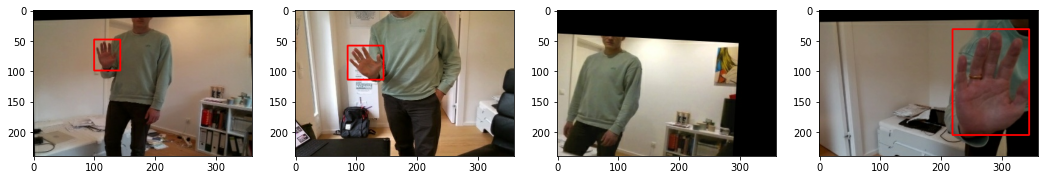

In [669]:
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(18, 12))

for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    #print(res)
    
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [360, 240]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [360, 240]).astype(int)),
                  (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# Build neuronal network

## Create NN model

In [515]:
def build_model():
    input_layer = Input(shape=(240, 360, 3))
    
    resized_img = Resizing(120,120)(input_layer)
    rescaled_img = Rescaling(1./255)(resized_img)
    
    vgg = VGG16(include_top=False, pooling='max')
    vgg.trainable = False
    vgg_output = vgg(rescaled_img)
    
    class1 = Dense(2048, activation='relu')(vgg_output)
    class2 = Dense(2, activation='sigmoid')(class1)
    
    regression1 = Dense(2048, activation='relu')(vgg_output)
    regression2 = Dense(4, activation='linear')(regression1) # changed from previously 'sigmoid'
    
    model = Model(inputs=input_layer, outputs=[class2, regression2])
    
    return model

In [516]:
handtracker = build_model()

In [517]:
handtracker.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 240, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 resizing_6 (Resizing)          (None, 120, 120, 3)  0           ['input_13[0][0]']               
                                                                                                  
 rescaling_6 (Rescaling)        (None, 120, 120, 3)  0           ['resizing_6[0][0]']             
                                                                                                  
 vgg16 (Functional)             (None, 512)          14714688    ['rescaling_6[0][0]']      

In [638]:
X, y = data_train.as_numpy_iterator().next()

In [639]:
X.shape

(8, 240, 360, 3)

In [640]:
y

(array([[1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0]], dtype=uint8),
 array([[0.40478802, 0.05751096, 0.5500731 , 0.31792763],
        [0.        , 0.        , 0.        , 0.        ],
        [0.05900877, 0.        , 0.45254   , 0.5413887 ],
        [0.12061404, 0.24802631, 0.41575292, 0.75104165],
        [0.22672956, 0.06041241, 0.30163598, 0.19770499],
        [0.41019014, 0.        , 0.54200864, 0.19416605],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32))

In [642]:
classes, coords = handtracker.predict(X)
classes, coords

(array([[1.0000000e+00, 1.0000000e+00],
        [1.7904536e-09, 1.6511413e-09],
        [1.0000000e+00, 1.0000000e+00],
        [1.0000000e+00, 1.0000000e+00],
        [9.9997902e-01, 9.9997997e-01],
        [1.0000000e+00, 1.0000000e+00],
        [1.7346782e-06, 1.8477829e-06],
        [6.8250602e-06, 7.0391297e-06]], dtype=float32),
 array([[ 0.39369243,  0.04298582,  0.55402386,  0.33158636],
        [ 0.039268  ,  0.02527757,  0.01869949,  0.03079895],
        [ 0.06452607, -0.02773638,  0.44705224,  0.5285099 ],
        [ 0.1370436 ,  0.26010624,  0.39131135,  0.7743476 ],
        [ 0.2309828 ,  0.0485044 ,  0.2967972 ,  0.20506449],
        [ 0.42401668,  0.02926211,  0.56580013,  0.20246175],
        [ 0.03781324,  0.01408796,  0.02478157,  0.01257083],
        [-0.00262407, -0.01769767,  0.00646557, -0.00596981]],
       dtype=float32))

## Define loss functions

In [522]:
# Define localization loss
def localization_loss(y_true, y_pred):
    """
    Calculates loss function for boundary box. Input needs to be nested list / numpy array with shape (1,4)
    """
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [523]:
# Define loss functions for model
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [524]:
# Test classloss
classloss(y[0], classes).numpy()

0.6546922

In [525]:
# Test regressloss
regressloss(y[1], coords).numpy()

16.124039

## Define model subclass and compile model

In [526]:
class HandTracker(Model):
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        
    def compile(self, opt, classloss, regressloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.rloss = regressloss
        self.opt = opt
        
    def train_step(self, batch, **kwargs):
        
        X, y = batch
        
        with tf.GradientTape() as tape:
            # Make a prediction
            classes, coords = self.model(X, training=True)
            
            # Calculate losses (y vs. prediction)
            batch_closs = self.closs(y[0], classes)
            batch_rloss = self.rloss(tf.cast(y[1], tf.float32), coords)  # cast can be deleted, once pipeline is rerun
            batch_total_loss = batch_closs + batch_rloss  # factor before batch_lloss to be optimized
            
            # Calculate gradients for trainable variables
            grad = tape.gradient(batch_total_loss, self.model.trainable_variables)
          
        # Change trainable variables in direction of gradient using opt algorithm 
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {'total_loss':batch_total_loss, 'class_loss':batch_closs, 'regression_loss':batch_rloss}
    
    def test_step(self, batch, **kwargs):
        
        X, y = batch
        
        # Make a prediction
        classes, coords = self.model(X, training=True)

        # Calculate losses (y vs. prediction) -> no gradient descent!!
        batch_closs = self.closs(y[0], classes)
        batch_rloss = self.rloss(tf.cast(y[1], tf.float32), coords)  # cast can be deleted, once pipeline is rerun
        batch_total_loss = batch_closs + batch_rloss  # factor before batch_lloss to be optimized

        return {'total_loss':batch_total_loss, 'class_loss':batch_closs, 'regression_loss':batch_rloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [617]:
handtracker = build_model()
model = HandTracker(handtracker)

In [618]:
# Determine optimizer
opt = Adam(0.0001, decay=0.00001) # (learning_rate=0.0001, decay=lr_decay) # Make sure Adam is loaded from tensorflow keras!!

In [619]:
model.compile(opt, classloss, regressloss)

## Train model

In [620]:
log_dir = 'logs'

In [621]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [622]:
history = model.fit(data_train, epochs=40, validation_data=data_val, callbacks=[tensorboard_callback])

Epoch 1/40
420/420 [==============================] - 30s 60ms/step - total_loss: 0.9218 - class_loss: 0.2370 - regression_loss: 0.6848 - val_total_loss: 0.1803 - val_class_loss: 0.0453 - val_regression_loss: 0.1350
Epoch 2/40
420/420 [==============================] - 28s 59ms/step - total_loss: 0.3190 - class_loss: 0.0630 - regression_loss: 0.2560 - val_total_loss: 0.2937 - val_class_loss: 0.0041 - val_regression_loss: 0.2896
Epoch 3/40
420/420 [==============================] - 29s 61ms/step - total_loss: 0.2316 - class_loss: 0.0340 - regression_loss: 0.1977 - val_total_loss: 0.3232 - val_class_loss: 0.0126 - val_regression_loss: 0.3106
Epoch 4/40
420/420 [==============================] - 32s 67ms/step - total_loss: 0.1670 - class_loss: 0.0213 - regression_loss: 0.1457 - val_total_loss: 0.0459 - val_class_loss: 0.0093 - val_regression_loss: 0.0366
Epoch 5/40
420/420 [==============================] - 35s 69ms/step - total_loss: 0.1548 - class_loss: 0.0153 - regression_loss: 0.1395 

Epoch 38/40
420/420 [==============================] - 35s 72ms/step - total_loss: 0.0200 - class_loss: 6.7955e-06 - regression_loss: 0.0199 - val_total_loss: 0.0599 - val_class_loss: 1.9263e-05 - val_regression_loss: 0.0598
Epoch 39/40
420/420 [==============================] - 36s 76ms/step - total_loss: 0.0244 - class_loss: 8.2380e-04 - regression_loss: 0.0236 - val_total_loss: 0.0554 - val_class_loss: 1.5748e-04 - val_regression_loss: 0.0552
Epoch 40/40
420/420 [==============================] - 38s 77ms/step - total_loss: 0.0175 - class_loss: 5.7037e-05 - regression_loss: 0.0175 - val_total_loss: 0.0415 - val_class_loss: 0.0000e+00 - val_regression_loss: 0.0415


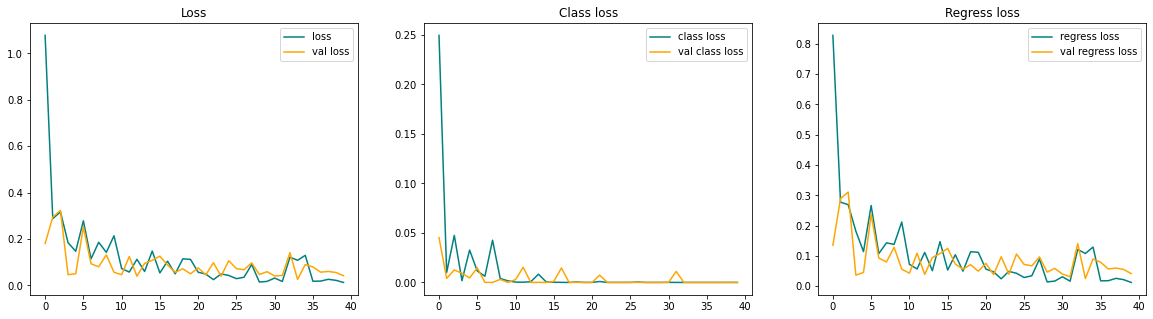

In [623]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='teal', label='loss')
ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['class_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Class loss')
ax[1].legend()

ax[2].plot(history.history['regression_loss'], color='teal', label='regress loss')
ax[2].plot(history.history['val_regression_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regress loss')
ax[2].legend()


## Make predictions

In [624]:
handtracker = model.model

In [632]:
data_test_iterator = data_test.as_numpy_iterator()

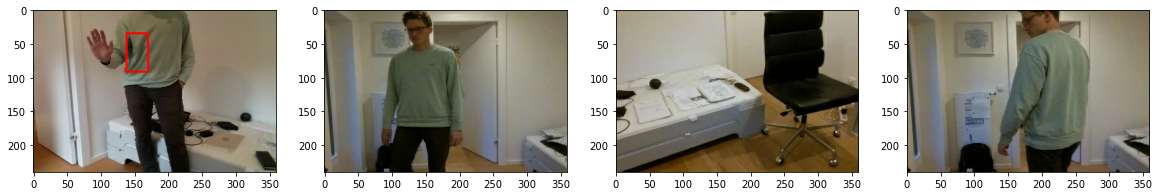

In [633]:
test_sample = data_test_iterator.next()
y_pred = handtracker.predict(test_sample[0])

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = y_pred[1][idx]
    
    if y_pred[0][idx, 0] > 0.5:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [360, 240]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [360, 240]).astype(int)),
                      (255,0,0), 2)
        
    ax[idx].imshow(sample_image)

In [551]:
handtracker.save('handtracker.h5')

# Real time detection

In [7]:
from tensorflow.keras.models import load_model

In [8]:
# Load model from h5 file hand_detection_model.ipynbre for testing purposes)
handtracker = load_model('handtracker.h5')

In [6]:
# Image capturing with Tello drone for real time testing

from datetime import datetime, timedelta

me = tello.Tello()
me.connect()
print(me.get_battery())

# Triger stream from drone
me.streamon()

# Initialize variables
datetime_prv = datetime.now() - timedelta(seconds=1)
prob_class_1 = 0

# Start streaming
while True:
    img = me.get_frame_read().frame
    img = cv2.resize(img, (360, 240))
    
    if datetime.now() >= datetime_prv + timedelta(seconds=0.5):
        img_trf = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_trf = img_trf.reshape(1, 240, 360, 3)
        y_pred = handtracker.predict(img_trf)
        coords = y_pred[1][0]
        prob_class_1 = y_pred[0][0, 1]
    
    if prob_class_1 > 0.5:
        
        # Draw bbox around hand
        cv2.rectangle(img,
                      tuple(np.multiply(coords[:2], [360, 240]).astype(int)),
                      tuple(np.multiply(coords[2:], [360, 240]).astype(int)),
                      (255,0,0), 2)
        
        # Draw label box
        cv2.rectangle(img,
                      tuple(np.add(np.multiply(coords[:2], [360, 240]).astype(int), [0, -30])),
                      tuple(np.add(np.multiply(coords[:2], [360, 240]).astype(int), [80, 0])),
                      (255,0,0), -1)
        
        # Put text in label
        cv2.putText(img, 'straight_hand', 
                    tuple(np.add(np.multiply(coords[:2], [360, 240]).astype(int), [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                   
    cv2.imshow("Image", img)
    cv2.waitKey(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

me.streamoff()
cv2.destroyAllWindows()

[INFO] tello.py - 122 - Tello instance was initialized. Host: '192.168.10.1'. Port: '8889'.
[INFO] tello.py - 437 - Send command: 'streamoff'
[INFO] tello.py - 461 - Response streamoff: 'ok'
Exception ignored in: <function Tello.__del__ at 0x111097af0>
Traceback (most recent call last):
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/enforce_types.py", line 54, in wrapper
    return func(*args, **kwargs)
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/tello.py", line 1019, in __del__
    self.end()
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/enforce_types.py", line 54, in wrapper
    return func(*args, **kwargs)
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/tello.py", line 1010, in end
    self.background_frame_read.stop()
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/tello.py", line 1074, in stop
    self.worker.join()
  File "/opt/mi

83


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/tello.py", line 1065, in update_frame
    self.stop()
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/site-packages/djitellopy/tello.py", line 1074, in stop
    self.worker.join()
  File "/opt/miniforge3/envs/tello_ai/lib/python3.9/threading.py", line 1050, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


error: OpenCV(4.5.5) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
